In [1]:
from glob import glob
from tqdm import tqdm
import pandas as pd
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
import scipy.stats as stats

In [2]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

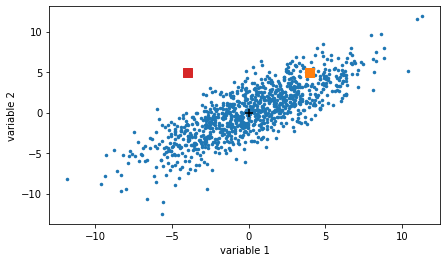

In [4]:
import numpy as np
import matplotlib.pyplot as plt

xx = np.array([-10, 10])
yy = np.array([-10, 10])
means = [xx.mean(), yy.mean()]  
stds = [xx.std() / 3, yy.std() / 3]
corr = 0.8         # correlation
covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr,           stds[1]**2]] 

m = np.random.multivariate_normal(means, covs, 1000).T
plt.rcParams["figure.figsize"] = (7, 4)
plt.scatter(m[0], m[1],marker=".",s=50, lw=0)
plt.scatter([-4,4], [5, 5], s=80, marker = "s", c=['#d62728', '#ff7f0e'])
plt.scatter([0], [0], s=60, marker = "+", c=['#000000'])
plt.xlabel("variable 1")
plt.ylabel("variable 2")
plt.savefig("correlated_variable.pdf", bbox_inches='tight')

In [19]:
m[0,:].shape

(1000,)

(2, 1000)


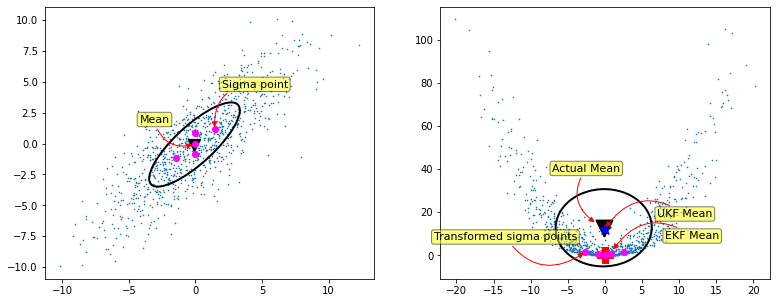

In [150]:
plt.rcParams["figure.figsize"] = (13, 5)
fig, axes = plt.subplots(1,2)
axes[0].scatter(m[0], m[1],marker=".",s=10, lw=0)
axes[0].scatter(m[0,:].mean(), m[1,:].mean(), marker='v',c=['#000000'],lw=1,s=150)

confidence_ellipse(m[0], m[1], axes[0], n_std=1, edgecolor='black',lw=2)


# create sigma points and weights
points = MerweScaledSigmaPoints(n=2, alpha=.3, beta=2., kappa=.1)
sigmas = points.sigma_points(means, covs)
axes[0].scatter(sigmas[:,0], sigmas[:,1],c=['#ff00ff'])


def f_nonlinear_xy(x, y):
    return np.array([x + y, .1*x**2 + y*y])

nl_m = f_nonlinear_xy(m[0], m[1])
linearized_mean = f_nonlinear_xy(*means)
print(nl_m.shape)

axes[1].scatter(nl_m[0], nl_m[1],marker=".",s=10, lw=0)
axes[1].scatter(linearized_mean[0], linearized_mean[1],marker="P", c=['#ff0000'],s=250)
axes[1].scatter(nl_m[0,:].mean(), nl_m[1,:].mean(), marker='v',c=['#000000'],lw=2,s=250)
confidence_ellipse(nl_m[0], nl_m[1], axes[1], n_std=1, edgecolor='black',lw=2)


### pass through nonlinear function
sigmas_f = np.empty((5, 2))
for i in range(5):
    sigmas_f[i] = f_nonlinear_xy(sigmas[i, 0], sigmas[i ,1])

    ### use unscented transform to get new mean and covariance
ukf_mean, ukf_cov = unscented_transform(sigmas_f, points.Wm, points.Wc)
axes[1].scatter(ukf_mean[0], ukf_mean[1], marker='*',c=['#0000ff'],s=150)
axes[1].scatter(sigmas_f[:,0], sigmas_f[:,1],c=['#ff00ff'])


axes[0].annotate('Mean', xy=(m[0,:].mean(), m[1,:].mean()), xytext=(-40,20), 
            textcoords='offset points', ha='center', va='bottom',size=11,
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3,rad=0.5', 
                            color='red'))
axes[0].annotate('Sigma point', xy=(sigmas[1,0], sigmas[1,1]), xytext=(+40,40), 
            textcoords='offset points', ha='center', va='bottom',size=11,
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3,rad=0.5', 
                            color='red'))

axes[1].annotate('Actual Mean', xy=(nl_m[0,:].mean()-1, nl_m[1,:].mean()+2), xytext=(-10,50), 
            textcoords='offset points', ha='center', va='bottom',size=11,
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3,rad=0.5', 
                            color='red'))

axes[1].annotate('UKF Mean', xy=(ukf_mean[0], ukf_mean[1]), xytext=(+80,10), 
            textcoords='offset points', ha='center', va='bottom',size=11,
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3,rad=0.5', 
                            color='red'))

axes[1].annotate('EKF Mean', xy=(linearized_mean[0]+1, linearized_mean[1]+2), xytext=(+80,10), 
            textcoords='offset points', ha='center', va='bottom',size=11,
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3,rad=0.5', 
                            color='red'))

axes[1].annotate('Transformed sigma points', xy=(sigmas_f[3,0], sigmas_f[3,1]), xytext=(-80,10), 
            textcoords='offset points', ha='center', va='bottom',size=11,
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3,rad=0.5', 
                            color='red'))
plt.savefig("ekf-ukf-comparison.pdf", bbox_inches='tight')

(2, 1000)
[[ 4.00000000e+01 -3.55271368e-15]
 [-3.55271368e-15  3.01122321e+02]]


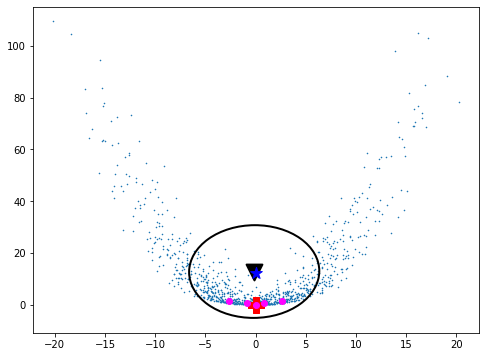

In [118]:


nl_m = f_nonlinear_xy(m[0], m[1])
linearized_mean = f_nonlinear_xy(*means)
print(nl_m.shape)
fig, ax = plt.subplots()
ax.scatter(nl_m[0], nl_m[1],marker=".",s=10, lw=0)
ax.scatter(linearized_mean[0], linearized_mean[1],marker="P", c=['#ff0000'],s=250)
ax.scatter(nl_m[0,:].mean(), nl_m[1,:].mean(), marker='v',c=['#000000'],lw=2,s=250)
confidence_ellipse(nl_m[0], nl_m[1], ax, n_std=1, edgecolor='black',lw=2)


### pass through nonlinear function
sigmas_f = np.empty((5, 2))
for i in range(5):
    sigmas_f[i] = f_nonlinear_xy(sigmas[i, 0], sigmas[i ,1])

    ### use unscented transform to get new mean and covariance
ukf_mean, ukf_cov = unscented_transform(sigmas_f, points.Wm, points.Wc)
ax.scatter(ukf_mean[0], ukf_mean[1], marker='*',c=['#0000ff'],s=150)
ax.scatter(sigmas_f[:,0], sigmas_f[:,1],c=['#ff00ff'])
print(ukf_cov)

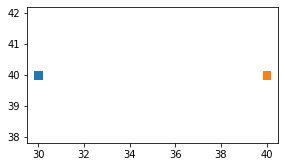

In [12]:
plt.scatter([30,40], [40, 40], s=60, marker = "s", c=['#1f77b4', '#ff7f0e'])

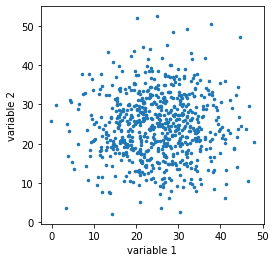

In [7]:
import numpy as np
import matplotlib.pyplot as plt

xx = np.array([0,50])
yy = np.array([0, 50])
means = [xx.mean(), yy.mean()]  
stds = [xx.std() / 3, yy.std() / 3]
corr = 0.8         # correlation
covs = [[stds[0]**2          , 1], 
        [1,           stds[1]**2]] 

m = np.random.multivariate_normal(means, covs, 700).T
plt.rcParams["figure.figsize"] = (4, 4)
plt.scatter(m[0], m[1],marker=".",s=50, lw=0)
# plt.scatter([40,60], [23, 23], s=80, marker = "s", c=['#d62728', '#ff7f0e'])
# plt.scatter([50], [15], s=60, marker = "+", c=['#000000'])
plt.xlabel("variable 1")
plt.ylabel("variable 2")
plt.savefig("non_correlated_variable.pdf", bbox_inches='tight')

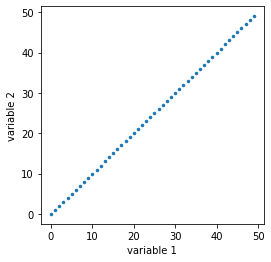

In [8]:
x = np.arange(0,50,1)
plt.scatter(x, x,marker=".",s=50, lw=0)
plt.xlabel("variable 1")
plt.ylabel("variable 2")
plt.savefig("full_correlated_variable.pdf", bbox_inches='tight')

### correlation of the 3d locations of the pedertians in kitti 

In [13]:
gt_files = sorted(glob("/home/eam/MasterThesis/Thesis/TrackEval/data/gt/kitti_lidar/kitti_2d_box_train/label_02/*"))
locs = np.empty(shape=(0,3))
for gt_file in tqdm(gt_files):
    with open(gt_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            splitted = line.split(" ")
            if splitted[2] == "Pedestrian":
                threeD_loc = np.array([float(x) for x in splitted[13:16]]).reshape((1,3))
                locs = np.vstack((locs, threeD_loc))
                
    
            

100%|██████████████████████████████████████████| 21/21 [00:00<00:00, 104.64it/s]


In [14]:
locs.shape

(11470, 3)

### plot x to y

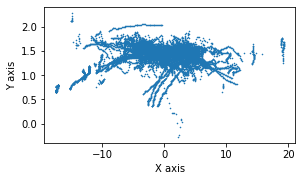

In [16]:
plt.rcParams["figure.figsize"] = (4.5, 2.5)
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.scatter(locs[:,0],locs[:,1],marker=".",s=10, lw=0)
plt.savefig("cov_x2y.pdf", bbox_inches='tight')

### plot x to z

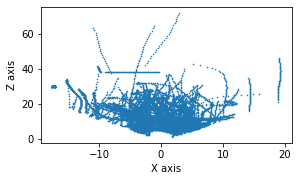

In [17]:
plt.xlabel("X axis")
plt.ylabel("Z axis")
plt.scatter(locs[:,0],locs[:,2],marker=".",s=10, lw=0)
plt.savefig("cov_x2z.pdf", bbox_inches='tight')

### plot y to z

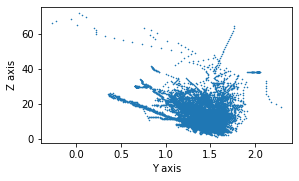

In [19]:
plt.xlabel("Y axis")
plt.ylabel("Z axis")
plt.scatter(locs[:,1],locs[:,2],marker=".",s=10, lw=0)
plt.savefig("cov_y2z.pdf", bbox_inches='tight')

In [83]:
df = pd.DataFrame(locs)
df.corr()

0         1         2
0  1.00000  0.092990 -0.260420
1  0.09299  1.000000 -0.341262
2 -0.26042 -0.341262  1.000000

In [98]:
df.cov()

0         1          2
0  30.340051  0.122733 -11.377737
1   0.122733  0.057417  -0.648606
2 -11.377737 -0.648606  62.914050